In [1]:
# will run for a few minutes
!pip install odefinterp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 57.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 70.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.5 MB/s eta 0:0

In [2]:
import odeformer
from odeformer.model import SymbolicTransformerRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import torch, json
import numpy as np

In [12]:
dstr = SymbolicTransformerRegressor(from_pretrained=True)
# i'll suggest you keep the beam size low. you'll know why.
model_args = {'beam_size':5, 'beam_temperature':0.1}
dstr.set_model_args(model_args)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [39]:
# first example
times = np.linspace(0, 10, 25)
x = 2.3 * np.cos(times + 0.5)
y = 1.2 * np.sin(times + 0.1)
trajectory = np.stack([x, y], axis=1)  # (time, state) format

In [13]:
# second example (was supposed to be the easiest until noise entered the chat)
times = np.linspace(0, 10, 50)
x0_init = 2.0
x1_init = 2.0
c0 = 0.5
c1 = -0.3

# trajectories
x0 = x0_init * np.exp(c0 * times)  # x_0(t) = x_0(0) * exp(c0 * t)
x1 = x1_init * np.exp(c1 * times)  # x_1(t) = x_1(0) * exp(c1 * t)
#trajectory = np.stack([x0, x1], axis=1)
trajectory = np.stack([x1], axis=1)

Skipping encoder block...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...
Skipping suspicious single beam business...


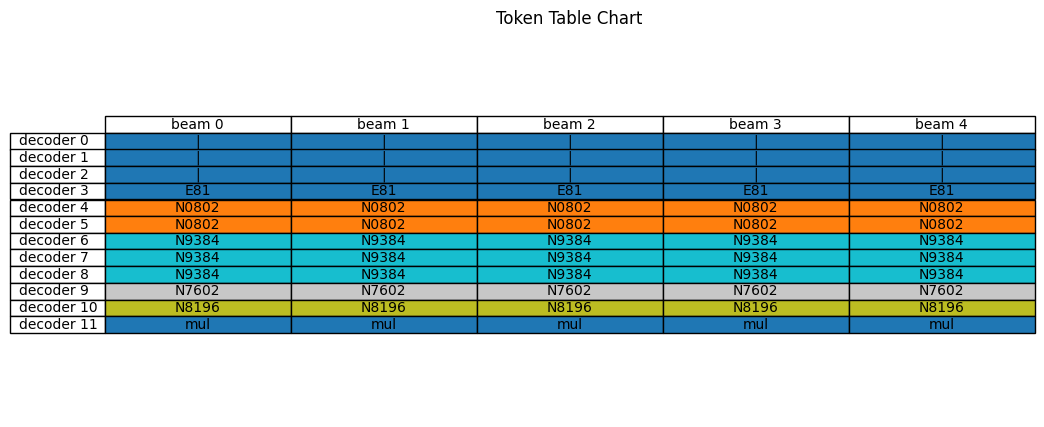

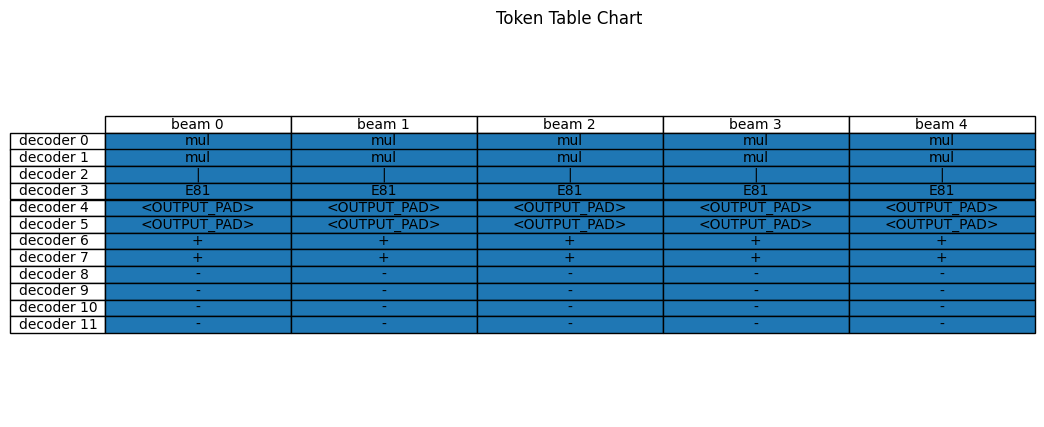

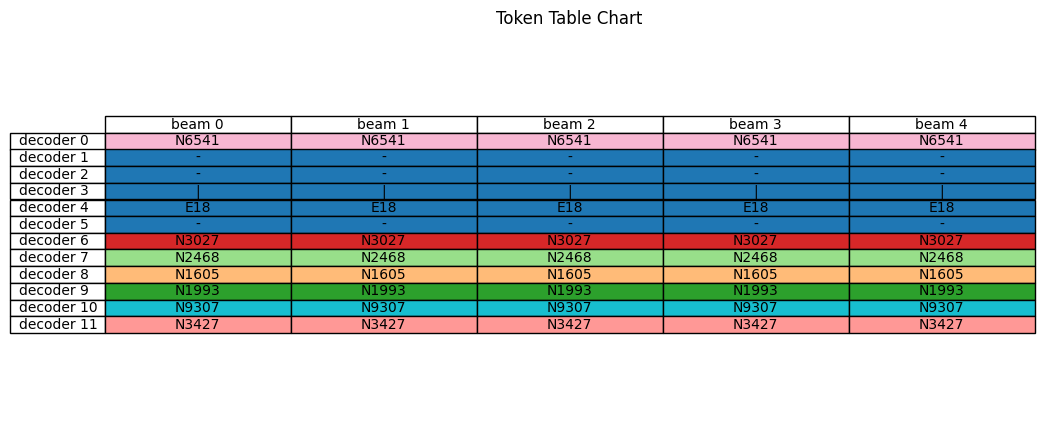

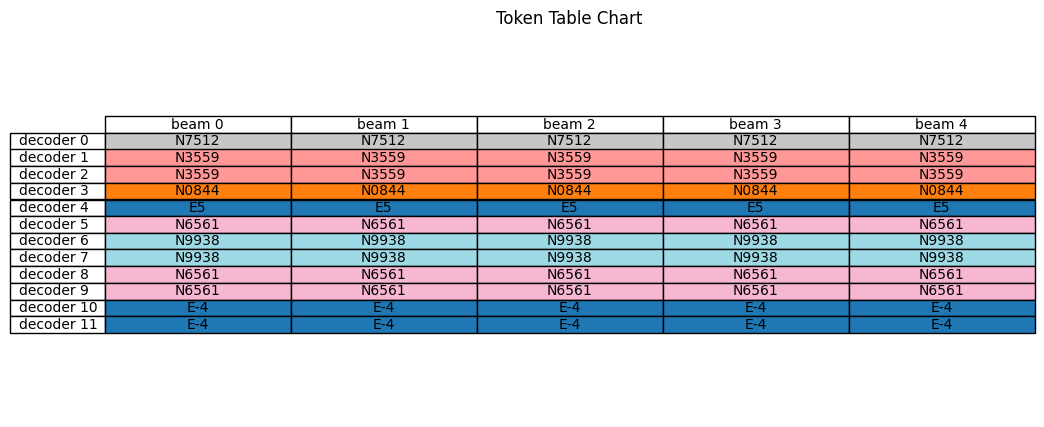

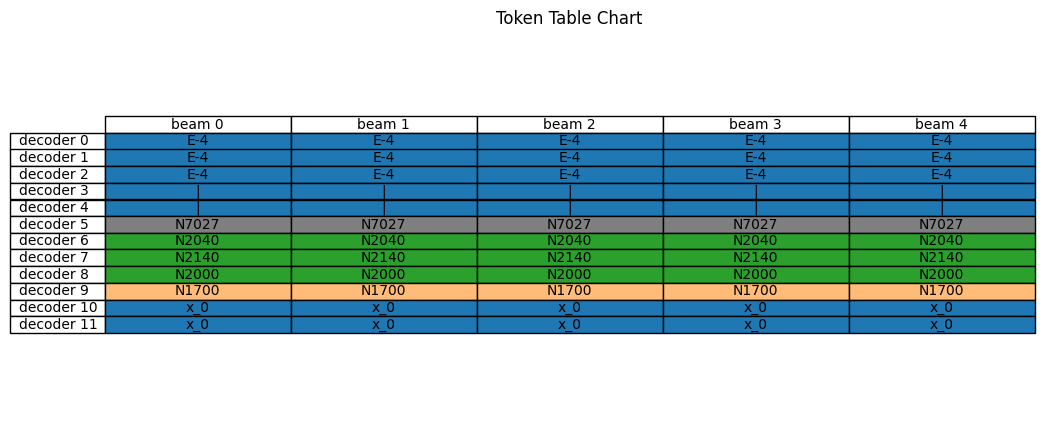

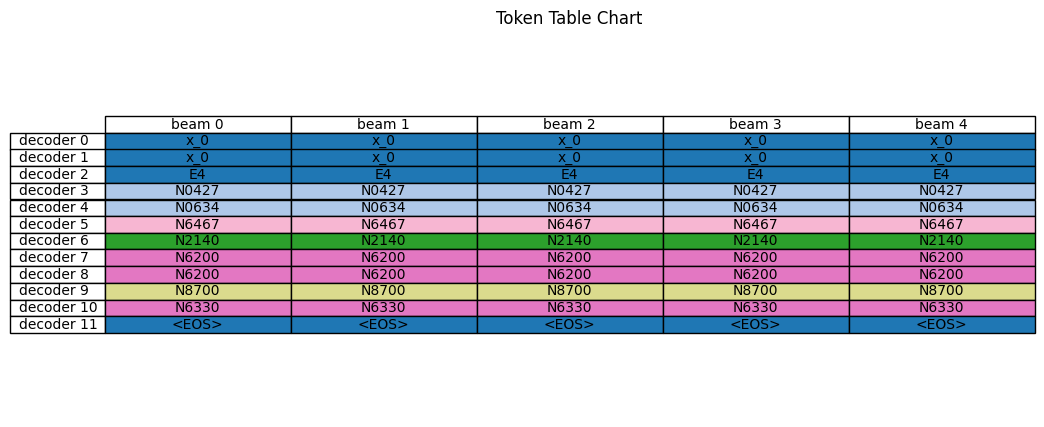

x_0' = -0.3084 * x_0
R2 Score: 0.9991719997320817


In [14]:
candidates = dstr.fit(times, trajectory)
dstr.print(n_predictions=1)
pred_trajectory = dstr.predict(times, trajectory[0])

# evaluating prediction using R2 score
from odeformer.metrics import r2_score
print("R2 Score:", r2_score(trajectory, pred_trajectory))

In [15]:
# size is (n_tokens, n_layers, beam_size)
intermediate_tokens = list(dstr.get_intermediate_tokens().values())
len(intermediate_tokens)

6

In [16]:
all_attentions = dstr.get_stored_attentions()
for i in list(all_attentions.keys()):
    if i == "encoder":
        print("all_attentions['"+i+"'] -> ", torch.tensor(all_attentions[i]).shape)
    else:
        for j in ["decoder", "cross_attention"]:
            print("all_attentions['"+i+"']['"+j+"'] -> ", torch.tensor(all_attentions[i][j]).shape)

all_attentions['encoder'] ->  torch.Size([4, 1, 16, 50, 50])
all_attentions['token_0']['decoder'] ->  torch.Size([12, 1, 16, 1, 1])
all_attentions['token_0']['cross_attention'] ->  torch.Size([12, 1, 16, 1, 50])
all_attentions['token_1']['decoder'] ->  torch.Size([12, 1, 16, 1, 2])
all_attentions['token_1']['cross_attention'] ->  torch.Size([12, 1, 16, 1, 50])
all_attentions['token_2']['decoder'] ->  torch.Size([12, 1, 16, 1, 3])
all_attentions['token_2']['cross_attention'] ->  torch.Size([12, 1, 16, 1, 50])
all_attentions['token_3']['decoder'] ->  torch.Size([12, 1, 16, 1, 4])
all_attentions['token_3']['cross_attention'] ->  torch.Size([12, 1, 16, 1, 50])
all_attentions['token_4']['decoder'] ->  torch.Size([12, 1, 16, 1, 5])
all_attentions['token_4']['cross_attention'] ->  torch.Size([12, 1, 16, 1, 50])
all_attentions['token_5']['decoder'] ->  torch.Size([12, 1, 16, 1, 6])
all_attentions['token_5']['cross_attention'] ->  torch.Size([12, 1, 16, 1, 50])
all_attentions['token_6']['decode

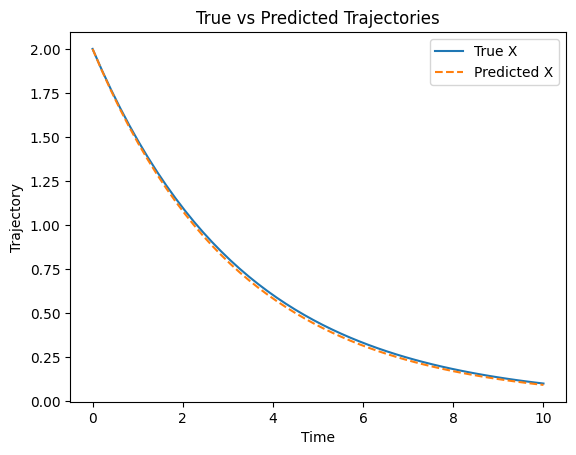

In [17]:
plt.plot(times, trajectory[:, 0], label='True X')
plt.plot(times, pred_trajectory[:, 0], label='Predicted X', linestyle='--')
#plt.plot(times, trajectory[:, 1], label='True Y')
#plt.plot(times, pred_trajectory[:, 1], label='Predicted Y', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Trajectory')
plt.title('True vs Predicted Trajectories')
plt.show()

In [ ]:
dstr.model

In [18]:
def plot_encoder_attention(attn):
    """
    Visualizes encoder self-attention.
    
    Args:
    - attn_weights (torch.Tensor): Shape [4, beam_size, 16, times, times]
    """
    # [num_blocks, batch, num_heads, seq_len, seq_len]    
    num_blocks, num_heads, seq_len = attn.shape[0], attn.shape[2], attn.shape[3]
    
    fig = make_subplots(
        rows=5,
        cols=4,
        row_heights=[0.4, 0.15, 0.15, 0.15, 0.15],
        vertical_spacing=0.06,
        horizontal_spacing=0.05,
        specs=[
            [{"colspan": 4}, None, None, None],  # row 1 for sum of heads
            [{}, {}, {}, {}],                   # rows 2..5 for 16 heads
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
        ],
        subplot_titles=["Normalized Sum of Heads"] + [f"Head {i}" for i in range(num_heads)]
    )
    
    def head_pos(i):
        row = (i // 4) + 2
        col = (i % 4) + 1
        return row, col
    
    # Initial block=0 data
    sum_map = attn[0, 0].sum(dim=0)
    if sum_map.max() != 0:
        sum_map = sum_map / sum_map.max()
    sum_trace = go.Heatmap(z=sum_map.cpu().numpy(), coloraxis="coloraxis", name="Sum0")
    fig.add_trace(sum_trace, row=1, col=1)
    
    # the 16-headed beast
    for head_idx in range(num_heads):
        hm = attn[0, 0, head_idx]
        if hm.max() != 0:
            hm = hm / hm.max()
        heatmap = go.Heatmap(z=hm.cpu().numpy(), coloraxis="coloraxis", name=f"Head{head_idx}-0")
        r, c = head_pos(head_idx)
        fig.add_trace(heatmap, row=r, col=c)
    
    # Build frames for each block
    frames = []
    for block_idx in range(num_blocks):
        sum_map = attn[block_idx, 0].sum(dim=0)
        if sum_map.max() != 0:
            sum_map /= sum_map.max()
        frame_data = [go.Heatmap(z=sum_map.cpu().numpy(), coloraxis="coloraxis")]  # sum
    
        for head_idx in range(num_heads):
            hm = attn[block_idx, 0, head_idx]
            if hm.max() != 0:
                hm /= hm.max()
            frame_data.append(go.Heatmap(z=hm.cpu().numpy(), coloraxis="coloraxis"))
    
        frames.append(go.Frame(name=f"block_{block_idx}", data=frame_data))
    
    fig.update(frames=frames)
    
    updatemenus = [
        dict(
            type="dropdown",
            x=0.0,
            xanchor="left",
            y=1.25,
            yanchor="top",
            showactive=True,
            direction="down",
            buttons=[
                dict(
                    label=f"Encoder Block {b}",
                    method="animate",
                    args=[
                        [f"block_{b}"],
                        dict(mode="immediate", frame=dict(duration=0, redraw=True), transition=dict(duration=0))
                    ],
                )
                for b in range(num_blocks)
            ],
        )
    ]
    
    # flipping vertically because somehow before they got flipped
    for r in range(1, len(intermediate_tokens)):
        for c in range(1, len(intermediate_tokens) - 1):
            fig.update_yaxes(autorange='reversed', row=r, col=c)
    
    fig.update_layout(
        coloraxis=dict(colorscale="Viridis"),
        height=1500,
        width=800,
        updatemenus=updatemenus,
        title_text="Encoder Self-Attention Visualization",
        title_x=0.5
    )
    
    fig.show()

In [19]:
plot_encoder_attention(torch.tensor(all_attentions["encoder"]))

In [20]:
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def stack_decoder_attentions(all_attentions):
    """
    Gather the decoder attentions for tokens that have beam_size=5
    and stack them into a single 5D tensor: [num_layers, beam_size, num_heads, max_tokens, max_tokens].
    
    all_attentions['token_i']['decoder'] has shape [num_layers, beam, num_heads, 1, seq_len].
    We want to unify seq_len across tokens, up to the max seq_len in that set.
    
    :param all_attentions: Dictionary with structure described in the conversation.
    :param tokens_range: The tokens that have beam=5 (e.g. 6..11).
    :return: A tensor shaped [num_layers, beam=5, num_heads=16, max_tokens, max_tokens]
    """
    # Collect shapes
    # For each token i in [6..11], shape is [12, 5, 16, 1, actual_len]
    shapes = []
    for t in range(len(intermediate_tokens), 2 * (len(intermediate_tokens)-1)):
        dec_attn = torch.tensor(all_attentions[f"token_{t}"]["decoder"])
        # dec_attn.shape -> [num_layers, beam_size, num_heads, 1, seq_len]
        shapes.append(dec_attn.shape[-1])
    max_len = max(shapes)  # largest seq_len
    num_layers = dec_attn.shape[0]
    beam = dec_attn.shape[1]
    num_heads = dec_attn.shape[2]
    
    # Prepare output [num_layers, beam, num_heads, max_len, max_len]
    # We'll fill with zeros for missing tokens
    stacked = torch.zeros(num_layers, beam, num_heads, max_len, max_len)
    
    # Fill it
    for tok_i, t in enumerate(range(len(intermediate_tokens), 2 * (len(intermediate_tokens)-1))):
        dec_attn = torch.tensor(all_attentions[f"token_{t}"]["decoder"])  # [12, 5, 16, 1, seq_len]
        seq_len = dec_attn.shape[-1]
        # dec_attn.squeeze(3) -> [12, 5, 16, seq_len]
        dec_attn_4d = dec_attn.squeeze(3)  # remove the dimension of size=1
        # Place it at dimension [..., tok_i, :seq_len], but we want a final shape of [..., max_len, max_len]
        # So we treat 'tok_i' as the row dimension, and we replicate 'seq_len' for the col dimension.
        # For simplicity, let's assume we store each token along both row & col dims, up to seq_len:
        # stacked[..., tok_i:tok_i+seq_len, tok_i:tok_i+seq_len] = dec_attn_4d
        # But the user specifically wants [6 tokens x 6 tokens]. So let's interpret each token as 1 step.
        # We'll place dec_attn in row=tok_i, col=0..(seq_len-1). You can adapt if needed.
        # For a simpler approach, place the entire 4D block in [row, col], as if each token adds 1 row:
        # We'll just do a minimal approach: if seq_len <= max_len - tok_i
        # This part can vary depending on how you want to glue them.
        
        for layer_idx in range(num_layers):
            for b in range(beam):
                for head_idx in range(num_heads):
                    # Put dec_attn_4d[layer_idx, b, head_idx, 0:seq_len]
                    stacked[
                        layer_idx,
                        b,
                        head_idx,
                        tok_i,                 # row index
                        0:seq_len             # col index
                    ] = dec_attn_4d[layer_idx, b, head_idx, :]
    
    return stacked

def build_figure(decoder_attn):
    """
    Build a Plotly figure with 2 dropdowns: 'block' (dec layer) and 'beam'.
    decoder_attn_5d shape: [num_layers, beam, num_heads, max_tokens, max_tokens].
    """
    num_layers, beam_size, num_heads, max_tokens, _ = decoder_attn.shape

    # We'll create subplots: row=1 for sum of heads, rows=2..5 for the 16 heads (4x4).
    fig = make_subplots(
        rows=5,
        cols=4,
        row_heights=[0.4, 0.15, 0.15, 0.15, 0.15],
        vertical_spacing=0.06,
        horizontal_spacing=0.06,
        specs=[
            [{"colspan": 4}, None, None, None],
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
        ],
        subplot_titles=["Normalized Sum of Heads"] + [f"Head {i}" for i in range(num_heads)]
    )

    def head_pos(i):
        row = (i // 4) + 2
        col = (i % 4) + 1
        return row, col
    
    # We prepare a huge list of traces. We'll have one trace group per (block, beam).
    # Each group has 1 "sum" + 16 "heads" = 17 total traces. We'll store them all but set "visible=False"
    # except for the default (block=0, beam=0).
    all_traces = []
    
    for layer_idx in range(num_layers):
        for b_idx in range(beam_size):
            block_beam_name = f"block_{layer_idx}-beam_{b_idx}"
            # shape [num_heads, max_tokens, max_tokens]
            data_3d = decoder_attn[layer_idx, b_idx]
            # sum over heads
            sum_map = data_3d.sum(dim=0)
            if sum_map.max() != 0:
                sum_map = sum_map / sum_map.max()
            sum_trace = go.Heatmap(
                z=sum_map.numpy(),
                coloraxis="coloraxis",
                name=block_beam_name + "-sum",
                visible=(layer_idx == 0 and b_idx == 0)
            )
            all_traces.append(sum_trace)
            
            # each head
            for head_idx in range(num_heads):
                head_map = data_3d[head_idx]
                if head_map.max() != 0:
                    head_map = head_map / head_map.max()
                trace = go.Heatmap(
                    z=head_map.numpy(),
                    coloraxis="coloraxis",
                    name=block_beam_name + f"-head_{head_idx}",
                    visible=(layer_idx == 0 and b_idx == 0)
                )
                all_traces.append(trace)
    
    # Add them to the figure. We'll add them in the same subplot positions each time, so
    # each block/beam is "stacked" but only one is visible at once.
    traces_per_group = 1 + num_heads  # sum + heads
    for idx, trace in enumerate(all_traces):
        # figure out which group index we are in
        group_idx = idx // traces_per_group  # which (block,beam) group
        trace_in_group = idx % traces_per_group
        # sum trace is 0, heads are 1..16
        if trace_in_group == 0:
            # sum
            fig.add_trace(trace, row=1, col=1)
        else:
            head_idx = trace_in_group - 1
            r, c = head_pos(head_idx)
            fig.add_trace(trace, row=r, col=c)
    
    # We'll build update menus to toggle (block_idx, beam_idx) by toggling "visible".
    # We have num_layers * beam_size groups, each 17 traces. We'll create 2 updatemenus:
    #  1) block dropdown
    #  2) beam dropdown
    # We'll store the "current" block & beam in layout "updatemenus" state, so changing one keeps the other.
    # The approach: each choice calls "restyle" and flips the visibility of all relevant traces.

    # Helper: turn everything invisible, except group = (layer, beam).
    def build_visibility_array(target_block, target_beam):
        visible_list = [False] * len(all_traces)
        group_count = num_layers * beam_size
        for group_i in range(group_count):
            b_idx = group_i // beam_size
            beam_i = group_i % beam_size
            # group=(b_idx, beam_i)
            # Actually we want group_i in [0..group_count-1],
            # block=group_i // beam_size, beam=group_i % beam_size
            if b_idx == target_block and beam_i == target_beam:
                start_idx = group_i * traces_per_group
                end_idx = start_idx + traces_per_group
                for k in range(start_idx, end_idx):
                    visible_list[k] = True
        return visible_list

    # Build block dropdown
    block_buttons = []
    for blk in range(num_layers):
        block_buttons.append(
            dict(
                label=f"Decoder Block {blk}",
                method="restyle",
                args=[
                    {"visible": build_visibility_array(blk, 0)},  # default beam=0, we override with the other menu
                ],
            )
        )
    # Build beam dropdown
    beam_buttons = []
    for b_idx in range(beam_size):
        beam_buttons.append(
            dict(
                label=f"Beam {b_idx}",
                method="restyle",
                args=[
                    {"visible": build_visibility_array(0, b_idx)},  # default block=0
                ],
            )
        )

    # We'll store "block" and "beam" as "active" items in each menu, but each menu call will override the entire array of visibility, erasing the other setting.  
    # To do a truly independent two-dropdown approach in static Plotly, we typically need a custom or repeated logic.  
    # For simplicity, let's do it so that changing block resets beam to 0, and changing beam resets block to 0. 
    # If you need them fully independent, you'd do a bigger JavaScript callback or a combined set of "block_{b}-beam_{g}" frames.

    # Combine menus
    updatemenus = [
        dict(type="dropdown", x=0.0, xanchor="left", y=1.29, yanchor="top", buttons=block_buttons),
        dict(type="dropdown", x=0.25, xanchor="left", y=1.29, yanchor="top", buttons=beam_buttons),
    ]

    # Flip each y-axis so it isn't upside-down
    for row_idx in range(1, len(intermediate_tokens)):
        for col_idx in range(1, len(intermediate_tokens) - 1):
            fig.update_yaxes(autorange="reversed", row=row_idx, col=col_idx)

    fig.update_layout(
        coloraxis=dict(colorscale="Viridis"),
        height=1500,
        width=800,
        updatemenus=updatemenus,
        title_text="Decoder Self-Attention Visualization",
        title_x=0.5
    )
    fig.show()

In [21]:
build_figure(stack_decoder_attentions(all_attentions))

In [24]:
def stack_cross_attentions(all_attentions):
    """
    Gathers the cross-attention tensors for tokens 6..11 and stacks them into:
      [num_layers=12, beam=5, num_heads=16, stacked_tokens=6, seq_len=50]
    Each original cross-attention has shape [12, 5, 16, 1, 50].
    """
    # Gather shapes
    # For each token i in [6..11], shape is [12, 5, 16, 1, 50]
    # We place each token along dimension 3 -> stacked_tokens.
    # So end shape: [12, 5, 16, 6, 50]
    tokens_range = (len(intermediate_tokens), 2 * (len(intermediate_tokens)-1))
    tok_count = tokens_range[1] - tokens_range[0] # + 1
    # We'll assume all have the same shape
    sample = torch.tensor(all_attentions[f"token_{tokens_range[0]}"]["cross_attention"])
    num_layers, beam_size, num_heads, _, seq_len = sample.shape

    # Prepare final tensor
    stacked = torch.zeros(num_layers, beam_size, num_heads, tok_count, seq_len)

    # Fill it
    for i, token_id in enumerate(range(tokens_range[0], tokens_range[1])):
        cross_attn = torch.tensor(all_attentions[f"token_{token_id}"]["cross_attention"])  # [12, 5, 16, 1, 50]
        # Remove the extra dimension
        cross_attn = cross_attn.squeeze(3)  # shape [12, 5, 16, 50]
        # Place it at dimension 3 => stacked[..., i, :]
        stacked[:, :, :, i, :] = cross_attn

    return stacked

def build_cross_figure(cross_attn):
    """
    Build a Plotly figure with 2 dropdowns: block (decoder layer) and beam.
    cross_attn_5d shape: [num_layers=12, beam=5, num_heads=16, 6, 50].
    We plot each (block, beam) as a set of 17 traces: sum-of-heads + 16 heads.
    The top row is a single big heatmap for sum-of-heads (shape [6, 50]).
    The lower rows are 4×4 subplots each showing [6, 50] for a single head.
    """
    num_layers, beam_size, num_heads, tok_dim, seq_len = cross_attn.shape     # 12

    # Create subplots: row=1 for sum of heads, rows=2..5 for the 16 heads.
    fig = make_subplots(
        rows=5,
        cols=4,
        row_heights=[0.4, 0.15, 0.15, 0.15, 0.15],
        vertical_spacing=0.06,
        horizontal_spacing=0.05,
        specs=[
            [{"colspan": 4}, None, None, None],  # sum-of-heads
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
            [{}, {}, {}, {}],
        ],
        subplot_titles=["Normalized Sum of Heads"] + [f"Head {i}" for i in range(num_heads)]
    )

    # Helper to map head index -> (row, col) in the 4×4 block
    def head_pos(i):
        row = (i // 4) + 2
        col = (i % 4) + 1
        return row, col

    # We'll create 17 traces per (block, beam). Each group has 1 "sum" + 16 heads.
    all_traces = []
    for layer_idx in range(num_layers):
        for b_idx in range(beam_size):
            # shape [num_heads, 6, 50]
            data_3d = cross_attn[layer_idx, b_idx]
            group_name = f"block_{layer_idx}-beam_{b_idx}"

            # sum-of-heads
            sum_map = data_3d.sum(dim=0)  # shape [6, 50]
            if sum_map.max() != 0:
                sum_map = sum_map / sum_map.max()
            sum_trace = go.Heatmap(
                z=sum_map.numpy(),
                coloraxis="coloraxis",
                name=group_name + "-sum",
                visible=(layer_idx == 0 and b_idx == 0)  # show only for 0,0 initially
            )
            all_traces.append(sum_trace)

            # 16 heads
            for head_idx in range(num_heads):
                hm = data_3d[head_idx]
                if hm.max() != 0:
                    hm = hm / hm.max()
                head_trace = go.Heatmap(
                    z=hm.numpy(),
                    coloraxis="coloraxis",
                    name=group_name + f"-head_{head_idx}",
                    visible=(layer_idx == 0 and b_idx == 0)
                )
                all_traces.append(head_trace)

    # Add them to figure, positioning in subplots
    # Each group has 17 traces. We'll add them in the same subplot positions.
    traces_per_group = 1 + num_heads
    for idx, trace in enumerate(all_traces):
        group_index = idx // traces_per_group
        which_in_group = idx % traces_per_group
        # sum trace is index 0, heads are index 1..16
        if which_in_group == 0:
            # sum-of-heads
            fig.add_trace(trace, row=1, col=1)
        else:
            head_idx = which_in_group - 1
            r, c = head_pos(head_idx)
            fig.add_trace(trace, row=r, col=c)

    # The updatemenus to toggle (block, beam) by toggling "visible" on/off
    def build_visibility(target_block, target_beam):
        """Return an array of booleans specifying which of the all_traces are visible."""
        vis = [False] * len(all_traces)
        grouping_count = num_layers * beam_size
        for group_i in range(grouping_count):
            blk = group_i // beam_size
            b   = group_i % beam_size
            if blk == target_block and b == target_beam:
                start_idx = group_i * traces_per_group
                end_idx   = start_idx + traces_per_group
                for k in range(start_idx, end_idx):
                    vis[k] = True
        return vis

    # "Block" dropdown resets beam to 0
    block_buttons = []
    for blk in range(num_layers):
        block_buttons.append(
            dict(
                label=f"Decoder Block {blk}",
                method="restyle",
                args=[
                    {"visible": build_visibility(blk, 0)}
                ],
            )
        )

    # "Beam" dropdown resets block to 0
    beam_buttons = []
    for b_idx in range(beam_size):
        beam_buttons.append(
            dict(
                label=f"Beam {b_idx}",
                method="restyle",
                args=[
                    {"visible": build_visibility(0, b_idx)}
                ],
            )
        )

    updatemenus = [
        dict(
            type="dropdown",
            x=0.0,
            xanchor="left",
            y=1.25,
            yanchor="top",
            direction="down",
            showactive=True,
            buttons=block_buttons
        ),
        dict(
            type="dropdown",
            x=0.25,
            xanchor="left",
            y=1.25,
            yanchor="top",
            direction="down",
            showactive=True,
            buttons=beam_buttons
        )
    ]

    # Flip the y-axes so they aren't upside down
    for r in range(1, len(intermediate_tokens)):
        for c in range(1, len(intermediate_tokens) - 1):
            fig.update_yaxes(autorange='reversed', row=r, col=c)

    fig.update_layout(
        coloraxis=dict(colorscale="Viridis"),
        height=1000,
        width=800,
        updatemenus=updatemenus,
        title_text="Cross-Attention Visualization",
        title_x=0.5
    )
    fig.show()

In [25]:
build_cross_figure(stack_cross_attentions(all_attentions))